In [1]:
# %% Imports
import torch
import torch.nn as nn
import torchvision
import torchvision.models as models
import torchvision.transforms as transforms
import numpy as np
import matplotlib.pyplot as plt
import torch.optim as optim
import copy
import pandas as pd
import time

# Set GPU device
print(torch.cuda.is_available())
device = torch.device("cuda:0")

True


In [2]:
# Download dataset from Google Drive
! gdown --id 1-6ekgyym3PYND6Z9oRlVo8sE5XV8B_km

# Links

# Zero Pad 128: 1-9hnSKSnqQmELI5_PAPy9BhLDc-bKEbE

# White Pad 128: 1ZdK5f5rbR4E7rzzAIXm84L8Mjp9HCfS0

# Zero Pad 224: 1-9sy-KxqUqBsW-GcsvfThzQL-0QiMfBS

# White Pad 224: 1-6ekgyym3PYND6Z9oRlVo8sE5XV8B_km

# Zero Pad 512: 1-DYICH8IyqrQh--WprRTrpYDzS-QgUc0

# White Pad 512: 1-AmotnWWdvKNxYlkGCS4BkrLY1BnrnaU

/usr/local/lib/python3.10/dist-packages/gdown/cli.py:138: FutureWarning: Option `--id` was deprecated in version 4.3.1 and will be removed in 5.0. You don't need to pass it anymore to use a file ID.
  warnings.warn(
Downloading...
From (original): https://drive.google.com/uc?id=1-6ekgyym3PYND6Z9oRlVo8sE5XV8B_km
From (redirected): https://drive.google.com/uc?id=1-6ekgyym3PYND6Z9oRlVo8sE5XV8B_km&confirm=t&uuid=0c03169a-a919-4b1c-96da-c8bda079fe36
To: /content/White_Pad_224.zip
100% 608M/608M [00:05<00:00, 103MB/s]


In [3]:
! mkdir data
!unzip White_Pad_224.zip

Streaming output truncated to the last 5000 lines.
  inflating: content/white_pad_224/1_Sclerotic/S-1909-007195_PAS_2of2_647582c3435c92704a444147.png  
  inflating: content/white_pad_224/1_Sclerotic/S-2006-001849_PAS_1of2_64542f6e435c92704a3575ff.png  
  inflating: content/white_pad_224/1_Sclerotic/S-1910-000090_PAS_1of2_64551d4e435c92704a3d0f4c.png  
  inflating: content/white_pad_224/1_Sclerotic/S-2102-006457_PAS_2of2_645527ff435c92704a3ef449.png  
  inflating: content/white_pad_224/1_Sclerotic/S-2010-013043_PAS_1of2_64552795435c92704a3e03c2.png  
  inflating: content/white_pad_224/1_Sclerotic/S-2006-003978_PAS_2of2_645432e3435c92704a38b27a.png  
  inflating: content/white_pad_224/1_Sclerotic/S-1908-009734_PAS_2of2_64551cdf435c92704a3c452b.png  
  inflating: content/white_pad_224/1_Sclerotic/S-2102-006457_PAS_2of2_645527ff435c92704a3ef441.png  
  inflating: content/white_pad_224/1_Sclerotic/S-2103-004716_PAS_2of2_64552857435c92704a3faeb0.png  
  inflating: content/white_pad_224/1_Scl

In [4]:
! mv content/* data

In [5]:
!pip install split-folders
import splitfolders
splitfolders.ratio('/content/data/white_pad_224', output="output", seed=1345, ratio=(0.8, 0.1,0.1))

Copying files: 5758 files [00:01, 2988.41 files/s]


In [6]:
# use GPU if available
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')

In [7]:

TRAIN_ROOT = '/content/output/train'
VAL_ROOT = '/content/output/val'
TEST_ROOT = '/content/output/test'
train_dataset = torchvision.datasets.ImageFolder(root=TRAIN_ROOT)
val_dataset = torchvision.datasets.ImageFolder(root=VAL_ROOT)
test_dataset = torchvision.datasets.ImageFolder(root=TEST_ROOT)

In [8]:
# %% Building the model
class CNNModel(nn.Module):
    def __init__(self):
        super(CNNModel, self).__init__()
        self.vgg19 = models.vgg19(pretrained=True)

        for param in self.vgg19.parameters():
          param.requires_grad = False

        # Replace output layer according to our problem
        in_feats = self.vgg19.classifier[6].in_features
        self.vgg19.classifier[6] = nn.Linear(in_feats, 2)

    def forward(self, x):
        x = self.vgg19(x)
        return x

model = CNNModel()
model.to(device)
model

/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=VGG19_Weights.IMAGENET1K_V1`. You can also use `weights=VGG19_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/vgg19-dcbb9e9d.pth" to /root/.cache/torch/hub/checkpoints/vgg19-dcbb9e9d.pth
100%|██████████| 548M/548M [00:06<00:00, 95.5MB/s]


CNNModel(
  (vgg19): VGG(
    (features): Sequential(
      (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (1): ReLU(inplace=True)
      (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (3): ReLU(inplace=True)
      (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
      (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (6): ReLU(inplace=True)
      (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (8): ReLU(inplace=True)
      (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
      (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (11): ReLU(inplace=True)
      (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (13): ReLU(inplace=True)
      (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (15): ReLU(inplace=True)
      (16):

In [9]:
# %% Prepare data for pretrained model
train_dataset = torchvision.datasets.ImageFolder(
        root=TRAIN_ROOT,
        transform=transforms.Compose([
                      transforms.Resize((224,224)),
                      transforms.ToTensor()
        ])
)

test_dataset = torchvision.datasets.ImageFolder(
        root=TEST_ROOT,
        transform=transforms.Compose([
                      transforms.Resize((224,224)),
                      transforms.ToTensor()
        ])
)

val_dataset = torchvision.datasets.ImageFolder(
        root=VAL_ROOT,
        transform=transforms.Compose([
                      transforms.Resize((224,224)),
                      transforms.ToTensor()
        ])
)

#train_dataset[0][0].permute(1,2,0)


In [10]:
# %% Create data loaders
batch_size = 32
train_loader = torch.utils.data.DataLoader(
    train_dataset,
    batch_size=batch_size,
    shuffle=True
)

val_loader = torch.utils.data.DataLoader(
    val_dataset,
    batch_size=batch_size,
    shuffle=True
)

test_loader = torch.utils.data.DataLoader(
    test_dataset,
    batch_size=batch_size,
    shuffle=True
)

In [11]:
# %% Train
cross_entropy_loss = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.00001)


epochs = 50

# initialize losses
trainLoss = torch.zeros(epochs)
devLoss   = torch.zeros(epochs)
trainAcc  = torch.zeros(epochs)
devAcc    = torch.zeros(epochs)


# Start timing
torch.cuda.synchronize()
start_time = time.time()





# Iterate x epochs over the train data
for epoch in range(epochs):
    print(f'Epoch {epoch}')
    model.train()
    batchLoss = []
    batchAcc  = []

    for i, batch in enumerate(train_loader, 0):
        inputs, labels = batch
        inputs = inputs.to(device)
        labels = labels.to(device)
        optimizer.zero_grad()
        outputs = model(inputs)
        # Labels are automatically one-hot-encoded
        loss = cross_entropy_loss(outputs, labels)
        loss.backward()
        optimizer.step()
        print(loss.item())

        # loss and accuracy from this batch
        batchLoss.append(loss.item())
        batchAcc.append( torch.mean((torch.argmax(outputs,axis=1) == labels).float()).item() )
    # end of batch loop...

    # and get average losses and accuracies across the batches
    trainLoss[epoch] = np.mean(batchLoss)
    trainAcc[epoch]  = 100*np.mean(batchAcc)

    #### test performance
    model.eval() # switch to test mode
    X,y = next(iter(val_loader))

    # push data to GPU
    X = X.to(device)
    y = y.to(device)

    # forward pass and loss
    with torch.no_grad():
      yHat = model(X)
      loss = cross_entropy_loss(yHat,y)

    # and get average losses and accuracies across the batches
    devLoss[epoch] = loss.item()
    devAcc[epoch]  = 100*torch.mean((torch.argmax(yHat,axis=1) == y).float()).item()

  # end epochs


# End timing
torch.cuda.synchronize()
end_time = time.time()

# Calculate elapsed time
gpu_time = end_time - start_time
print(f"GPU time for training: {gpu_time:.2f} seconds")

Streaming output truncated to the last 5000 lines.
0.23909471929073334
0.5342538952827454
0.2221054583787918
0.18018478155136108
0.24009408056735992
0.26345449686050415
0.19463418424129486
0.3216205835342407
0.22589367628097534
0.313431054353714
0.23118342459201813
0.2827779948711395
0.30535534024238586
0.32998159527778625
0.3100531995296478
0.2540174126625061
0.39462727308273315
0.21535688638687134
0.20552705228328705
0.2695191204547882
0.2441897839307785
0.22176504135131836
0.2005205750465393
0.29735642671585083
0.31439682841300964
0.39780545234680176
0.22726459801197052
0.3622475862503052
0.2723100185394287
0.19665122032165527
0.23752164840698242
0.33081158995628357
0.28176775574684143
0.3114548921585083
0.31726714968681335
0.3151288628578186
0.2885880172252655
0.27322378754615784
0.3647714853286743
0.21365803480148315
0.26311326026916504
0.25757020711898804
0.1761966049671173
0.18901917338371277
0.25313934683799744
0.30110135674476624
0.25330933928489685
0.29755479097366333
0.26862

In [12]:
test_data_loader = iter(test_loader)
count = 0
testAcc = 0
testLoss = 0

for i in range(1000000):
  # %% Inspect predictions for first batch
  import pandas as pd
  try:
    inputs, labels = next(test_data_loader)
    inputs = inputs.to(device)
    labels = labels.numpy()

    model.eval()
    with torch.no_grad():
      outputs = model(inputs).max(1).indices.detach().cpu().numpy()
      comparison = pd.DataFrame()
      print("Batch accuracy: ", (labels==outputs).sum()/len(labels))
      testAcc += (labels==outputs).sum()/len(labels)
      testLoss += loss.item()
      count += 1
      comparison["labels"] = labels

      comparison["outputs"] = outputs
      print(comparison)
  except StopIteration:
    break

testAcc = (testAcc/count) * 100
testLoss = (testLoss/count)

Batch accuracy:  0.96875
    labels  outputs
0        0        0
1        0        0
2        0        0
3        0        0
4        1        1
5        1        1
6        0        0
7        0        0
8        0        0
9        0        0
10       0        0
11       0        0
12       0        0
13       1        1
14       0        0
15       0        0
16       0        0
17       0        0
18       1        0
19       0        0
20       0        0
21       0        0
22       0        0
23       0        0
24       0        0
25       0        0
26       0        0
27       1        1
28       0        0
29       1        1
30       0        0
31       0        0
Batch accuracy:  0.90625
    labels  outputs
0        0        0
1        0        0
2        0        0
3        1        1
4        0        0
5        0        1
6        0        0
7        1        1
8        0        0
9        0        0
10       0        0
11       0        0
12       0        0
13       1

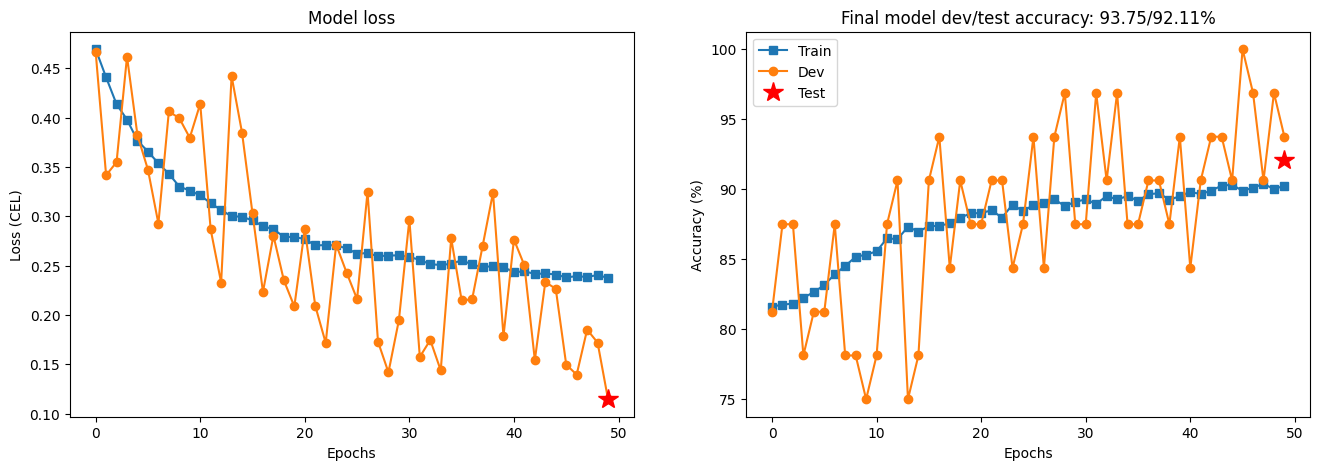

In [13]:
fig,ax = plt.subplots(1,2,figsize=(16,5))

ax[0].plot(trainLoss,'s-',label='Train')
ax[0].plot(devLoss,'o-',label='Dev')
ax[0].plot(len(devLoss)-1,testLoss,'r*',markersize=15,label='Test')
ax[0].set_xlabel('Epochs')
ax[0].set_ylabel('Loss (CEL)')
ax[0].set_title('Model loss')

ax[1].plot(trainAcc,'s-',label='Train')
ax[1].plot(devAcc,'o-',label='Dev')
ax[1].plot(len(devAcc)-1,testAcc,'r*',markersize=15,label='Test')
ax[1].set_xlabel('Epochs')
ax[1].set_ylabel('Accuracy (%)')
ax[1].set_title(f'Final model dev/test accuracy: {devAcc[-1]:.2f}/{testAcc:.2f}%')
ax[1].legend()

plt.show()

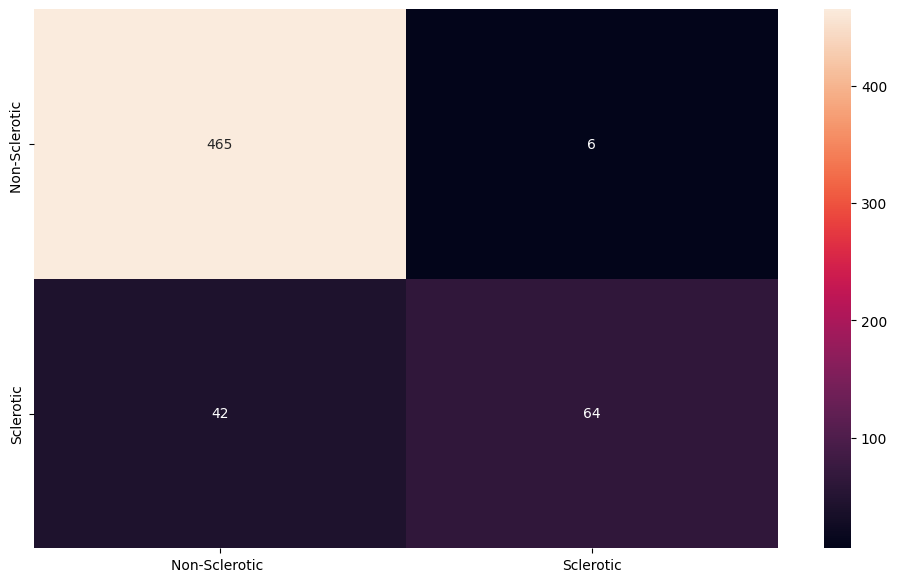

In [15]:
from sklearn.metrics import confusion_matrix
import seaborn as sn
import pandas as pd

y_pred = []
y_true = []

# iterate over test data
for inputs, labels in test_loader:
        # push data to GPU
        inputs = inputs.to(device)

        model.eval()
        # forward pass and loss
        with torch.no_grad():
            output = model(inputs) # Feed Network

        output = (torch.max(torch.exp(output), 1)[1]).data.cpu().numpy()
        y_pred.extend(output) # Save Prediction

        labels = labels.data.cpu().numpy()
        y_true.extend(labels) # Save Truth

# constant for classes
classes = ('Non-Sclerotic ', 'Sclerotic')

# Build confusion matrix
cf_matrix = confusion_matrix(y_true, y_pred)
df_cm = pd.DataFrame(cf_matrix, index = [i for i in classes], columns = [i for i in classes])
plt.figure(figsize = (12,7))
sn.heatmap(df_cm, annot=True, fmt='d')
plt.savefig('VGG19_Frozen_50epochs_confusion_matrix.png')
plt.show()

In [16]:
from sklearn.metrics import classification_report
print(classification_report(y_true, y_pred, target_names=['Non-Sclerotic ', 'Sclerotic']))

                precision    recall  f1-score   support

Non-Sclerotic        0.92      0.99      0.95       471
     Sclerotic       0.91      0.60      0.73       106

      accuracy                           0.92       577
     macro avg       0.92      0.80      0.84       577
  weighted avg       0.92      0.92      0.91       577



In [17]:
y_pred = []
y_true = []

# iterate over test data
for inputs, labels in test_loader:
        # push data to GPU
        inputs = inputs.to(device)

        model.eval()
        # forward pass and loss
        with torch.no_grad():
            output = model(inputs) # Feed Network

        #output = (torch.max(torch.exp(output), 1)[1]).data.cpu().numpy()
        raw_y_probs = output.detach().cpu()
        # Apply softmax to obtain probabilities
        y_probs = torch.softmax(raw_y_probs, dim=1)

        y_probs_np = y_probs.numpy()

        y_pred.extend(y_probs_np[:, 1]) # Save Prediction

        labels = labels.data.cpu().numpy()
        y_true.extend(labels) # Save Truth


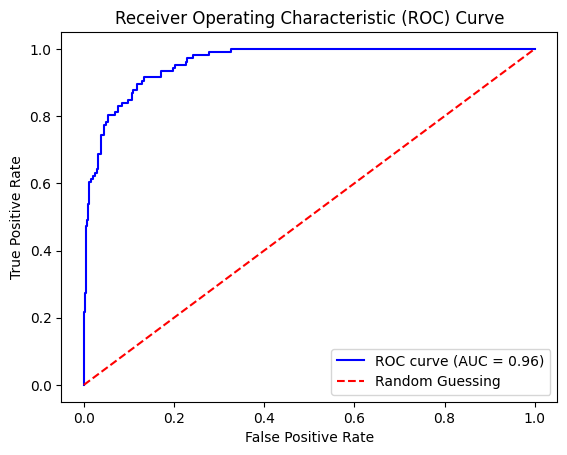

In [18]:
from sklearn.metrics import roc_curve, auc

# Calculate the false positive rate (FPR), true positive rate (TPR), and threshold values
fpr, tpr, thresholds = roc_curve(y_true, y_pred)

# Calculate the AUC (Area Under the Curve)
roc_auc = auc(fpr, tpr)

# Plot the ROC curve
plt.plot(fpr, tpr, color='blue', label='ROC curve (AUC = {:.2f})'.format(roc_auc))
plt.plot([0, 1], [0, 1], color='red', linestyle='--', label='Random Guessing')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend()
plt.savefig('VGG19_Frozen_50epochs_roc_auc.png')
plt.show()